In [37]:
import time
from collections import Counter
from collections.abc import Callable

import evaluate
import matplotlib.pyplot as plt
import numpy as np
import spacy
import torch
import torch.nn.functional as F  # noqa: N812
from spacy.language import Language
from torch import Tensor, nn
from tqdm import tqdm

import datasets

### Data processing

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    # for Apple chips
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(device)

mps


In [3]:
dataset = datasets.load_dataset("bentrevett/multi30k")

In [4]:
train_data, valid_data, test_data = (
    dataset["train"],
    dataset["validation"],
    dataset["test"],
)

In [5]:
train_data[0]

{'en': 'Two young, White males are outside near many bushes.',
 'de': 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.'}

In [6]:
# !python -m spacy download en_core_web_sm
# !python -m spacy download de_core_news_sm

In [7]:
en_nlp = spacy.load("en_core_web_sm")
de_nlp = spacy.load("de_core_news_sm")

In [8]:
string = "We're gonna go swimming"

[token.text for token in en_nlp.tokenizer(string)]

['We', "'re", 'gon', 'na', 'go', 'swimming']

In [9]:
def tokenize_example(example: dict[str, str],
                     en_nlp: Language,
                     de_nlp: Language,
                     max_length: int,
                     lower: bool,  # noqa: FBT001
                     bos_token: str,
                     eos_token: str) -> dict[str, list[str]]:
    en_tokens = [token.text for token in en_nlp.tokenizer(example["en"])][:max_length]
    de_tokens = [token.text for token in de_nlp.tokenizer(example["de"])][:max_length]

    if lower:
        en_tokens = [token.lower() for token in en_tokens]
        de_tokens = [token.lower() for token in de_tokens]

    en_tokens = [bos_token, *en_tokens, eos_token]
    de_tokens = [bos_token, *de_tokens, eos_token]

    return {"en_tokens": en_tokens, "de_tokens": de_tokens}

max_length = 1000
lower = True
sos_token = "<BOS>"  # noqa: S105
eos_token = "<EOS>"  # noqa: S105

fn_kwargs = {
    "en_nlp": en_nlp,
    "de_nlp": de_nlp,
    "max_length": max_length,
    "lower": lower,
    "bos_token": sos_token,
    "eos_token": eos_token,
}

train_data = train_data.map(tokenize_example, fn_kwargs=fn_kwargs)
valid_data = valid_data.map(tokenize_example, fn_kwargs=fn_kwargs)
test_data = test_data.map(tokenize_example, fn_kwargs=fn_kwargs)

Map: 100%|██████████| 1000/1000 [00:00<00:00, 17104.53 examples/s]


We build our own `Language` object that will adapt to a text corpus and store vocabulary.

In [10]:
class Language:
    def __init__(self, name: str = None, min_count: int = 2) -> None:
        self.name = name
        self._min_count = min_count

        self.index_to_word = {0: "<BOS>", 1: "<PAD>", 2: "<EOS>", 3: "<UNK>"}
        self.word_counts = Counter(self.index_to_word.values())

        self._last_index = list(self.index_to_word.keys())[-1]  # 3
        self._max_seq_length = 0

    def __repr__(self) -> None:
        return f"Language({self.name})"

    @property
    def max_seq_length(self) -> int:
        return self._max_seq_length

    @property
    def word_to_index(self) -> dict[str, int]:
        return {word: index for index, word in self.index_to_word.items()}

    @property
    def words(self) -> list[str]:
        return list(self.index_to_word.values())

    @property
    def num_words(self) -> int:
        return len(self.words)

    def get_word(self, idx: int) -> str:
        return self.index_to_word.get(idx, "<UNK>")

    def get_idx(self, word: str) -> int:
        return self.word_to_index.get(word, self.word_to_index["<UNK>"])

    def string(self, idxs: list[int] | Tensor) -> str:
        if isinstance(idxs, Tensor):
            idxs = idxs.cpu().detach().numpy().squeeze()

        return " ".join([self.get_word(idx) for idx in idxs])

    def indices(self, sentence: str | list[str]) -> list[int]:
        if isinstance(sentence, str):
            sentence = sentence.split()

        return [self.get_idx(word) for word in sentence]

    def add_word(self, word: str) -> None:
        if word not in self.words:
            self.word_counts.update([word])

            if self.word_counts[word] > self._min_count:
                # only update frequent words
                self.index_to_word[self._last_index + 1] = word
                self._last_index += 1

    def add_sentence(self, sentence: list[str]) -> None:
        seq_length = len(sentence)
        if seq_length > self._max_seq_length:
            self._max_seq_length = seq_length

        for word in sentence:
            self.add_word(word)

In [11]:
train_data.num_rows

29000

In [12]:
min_word_counts = 2
tgt_lang = Language("English", min_count=min_word_counts)
src_lang = Language("German", min_count=min_word_counts)

NUM_EXAMPLES = train_data.num_rows

# build vocabs
for example in train_data.take(NUM_EXAMPLES):
    src_lang.add_sentence(example["de_tokens"])
    tgt_lang.add_sentence(example["en_tokens"])

print(f"Max seq length src: {src_lang.max_seq_length}")
print(f"Max seq length tgt: {tgt_lang.max_seq_length}")

Max seq length src: 46
Max seq length tgt: 43


In [13]:
print(f"Vocab size src: {src_lang.num_words}")
print(f"Vocab size tgt: {tgt_lang.num_words}")

Vocab size src: 5374
Vocab size tgt: 4556


In [14]:
# def numericalize_example(example, tgt_lang: Language, src_lang: Language):
#     en_ids = tgt_lang.indices(example["en_tokens"])
#     de_ids = src_lang.indices(example["de_tokens"])
#     return {"en_ids": en_ids, "de_ids": de_ids}

# fn_kwargs = {"tgt_lang": tgt_lang, "src_lang": src_lang}

# train_data = train_data.take(NUM_EXAMPLES).map(numericalize_example, fn_kwargs=fn_kwargs)
# valid_data = valid_data.map(numericalize_example, fn_kwargs=fn_kwargs)
# test_data = test_data.map(numericalize_example, fn_kwargs=fn_kwargs)

# train_data.save_to_disk("datasets/train_data_de_en_v2.dataset")
# valid_data.save_to_disk("datasets/valid_data_de_en_v2.dataset")
# test_data.save_to_disk("datasets/test_data_de_en_v2.dataset")

# either load from disk or uncomment code above and run
train_data = datasets.load_from_disk("datasets/train_data_de_en_v2.dataset")
valid_data = datasets.load_from_disk("datasets/valid_data_de_en_v2.dataset")
test_data = datasets.load_from_disk("datasets/test_data_de_en_v2.dataset")

In [15]:
print(src_lang.string(train_data[2]["de_ids"]))
print(tgt_lang.string(train_data[2]["en_ids"]))

<BOS> ein kleines mädchen klettert in ein <UNK> aus holz . <EOS>
<BOS> a little girl climbing into a wooden playhouse . <EOS>


In [16]:
data_type = "torch"
format_columns = ["en_ids", "de_ids"]

train_data = train_data.with_format(
    type=data_type, columns=format_columns, output_all_columns=True
)

valid_data = valid_data.with_format(
    type=data_type, columns=format_columns, output_all_columns=True
)

test_data = test_data.with_format(
    type=data_type, columns=format_columns, output_all_columns=True
)

In [18]:


def get_collate_fn(pad_index: int) -> Callable[[dict], dict]:
    def collate_fn(batch: dict) -> dict[str, int]:
        batch_en_ids = [example["en_ids"] for example in batch]
        batch_de_ids = [example["de_ids"] for example in batch]
        batch_en_ids = nn.utils.rnn.pad_sequence(batch_en_ids, padding_value=pad_index)
        batch_de_ids = nn.utils.rnn.pad_sequence(batch_de_ids, padding_value=pad_index)
        return {
            "en_ids": batch_en_ids,
            "de_ids": batch_de_ids,
        }

    return collate_fn

def get_data_loader(dataset: datasets.Dataset, batch_size: int, pad_index: int, *,
                    shuffle: bool = True, pin_memory: bool = False) -> torch.utils.data.DataLoader:
    collate_fn = get_collate_fn(pad_index)
    return torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
        pin_memory=pin_memory,
    )

batch_size = 128

train_data_loader = get_data_loader(train_data, batch_size, tgt_lang.word_to_index["<PAD>"])
valid_data_loader = get_data_loader(valid_data, batch_size, tgt_lang.word_to_index["<PAD>"])
test_data_loader = get_data_loader(test_data, batch_size, tgt_lang.word_to_index["<PAD>"])

### Model

In [25]:
class MultiHeadAttention(nn.Module):
    def __init__(self, hidden_dim: int, num_heads: int, dropout_ratio: float = 0.1):
        if hidden_dim % num_heads != 0:
            msg = "hidden_dim must be divisible by num_heads"
            raise ValueError(msg)

        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.head_dim = hidden_dim // num_heads

        self.fc_q = nn.Linear(hidden_dim, hidden_dim)
        self.fc_k = nn.Linear(hidden_dim, hidden_dim)
        self.fc_v = nn.Linear(hidden_dim, hidden_dim)

        self.out = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_ratio)

        self.scaling = 1 / (self.head_dim ** .5)

    def forward(self, q: Tensor, k: Tensor, v: Tensor, mask: Tensor = None) -> Tensor:
        """
        Inputs
            q: query of size (batch_size, seq_length, hidden_dim)
            k: query of size (batch_size, seq_length, hidden_dim)
            v: query of size (batch_size, seq_length, hidden_dim)
            mask: optional mask of size (batch_size, 1, 1, seq_length)
                  or (batch_size, 1, seq_length, seq_length)
        Outputs
            attention weighted embedding vectors of size (batch_size, seq_length, hidden_dim)
        """
        # all Q, K, V are of shape (batch_size, seq_length, hidden_dim)
        Q = self.fc_q(q)
        K = self.fc_k(k)
        V = self.fc_v(v)

        batch_size, seq_length, _ = Q.size()

        # all Q, K, V are of shape (batch_size, num_heads, seq_length, head_dim)
        Q = Q.view(batch_size, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)

        # energy.shape (batch_size, num_heads, seq_length, seq_length)
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) * self.scaling  # type: Tensor

        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)

        # attention.shape (batch_size, num_heads, seq_length, seq_length)
        attention = energy.softmax(dim=-1)
        attention = self.dropout(attention)

        # x.shape (batch_size, num_heads, seq_length, head_dim)
        x = torch.matmul(attention, V)

        # x.shape (batch_size, seq_length, num_heads, head_dim)
        x = x.permute(0, 2, 1, 3)

        # x.shape (batch_size, seq_length, hidden_dim)
        x = x.reshape(batch_size, seq_length, self.hidden_dim)

        # x.shape (batch_size, seq_length, hidden_dim)
        x = self.out(x)

        return x

In [26]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, hidden_dim: int, ff_dim: int, dropout_ratio: float = 0.1):
        super().__init__()

        self.fc_1 = nn.Linear(hidden_dim, ff_dim)
        self.fc_2 = nn.Linear(ff_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, x) -> Tensor:
        # x.shape (batch_size, seq_length, emb_dim)
        x = self.fc_1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc_2(x)
        return x

class EncoderLayer(nn.Module):
    def __init__(self, hidden_dim: int, num_heads: int, ff_dim:int, dropout_ratio: float = 0.1):
        super().__init__()

        self.norm_1 = nn.LayerNorm(hidden_dim)
        self.norm_2 = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout_ratio)
        self.ff = PositionWiseFeedForward(hidden_dim=hidden_dim, ff_dim=ff_dim)

        self.mha = MultiHeadAttention(hidden_dim=hidden_dim,
                                      num_heads=num_heads,
                                      dropout_ratio=dropout_ratio)

    def forward(self, src: Tensor, mask: Tensor | None = None) -> Tensor:
        """
        Inputs
            input of size (batch_size, seq_length, hidden_dim)
        Outputs
            (batch_size, seq_length, hidden_dim)
        """
        # x1.shape (batch_size, seq_length, hidden_dim)
        x1 = self.mha(src, src, src, mask)  # type: Tensor
        x1 = self.norm_1(self.dropout(x1) + src)

        # x2.shape (batch_size, seq_length, hidden_dim)
        x2 = self.ff(x1)
        x2 = self.norm_2(x1 + self.dropout(x2))

        return x2

In [27]:
class Encoder(nn.Module):
    def __init__(self, vocab_size: int, hidden_dim: int,
                 num_heads: int, num_layers: int, ff_dim: int, max_seq_length: int,
                 device: torch.device, dropout_ratio: float = 0.1):
        super().__init__()

        self.device = device
        self.scaling = hidden_dim ** (0.5)

        self.token_embedding = nn.Embedding(vocab_size, hidden_dim)
        self.positional_embedding = nn.Embedding(max_seq_length, hidden_dim)
        self.dropout = nn.Dropout(dropout_ratio)

        self.layers = nn.ModuleList([EncoderLayer(hidden_dim=hidden_dim,
                                                  num_heads=num_heads, ff_dim=ff_dim,
                                                  dropout_ratio=dropout_ratio)
                                     for _ in range(num_layers)])

    def forward(self, src: Tensor, mask: Tensor | None = None) -> Tensor:
        """
        Inputs
            input of shape (batch_size, seq_legth)
        Outputs
            encoded sequence of shape (batch_size, seq_legth, hidden_dim)
        """
        batch_size, seq_length = src.size()
        positions = torch.arange(0, seq_length).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        # x.shape (batch_size, seq_legth, hidden_dim)
        x = self.token_embedding(src) * self.scaling + self.positional_embedding(positions)
        x = self.dropout(x)

        for layer in self.layers:
            # x.shape (batch_size, seq_legth, hidden_dim)
            x = layer(x, mask)

        return x

In [28]:
class DecoderLayer(nn.Module):
    def __init__(self, hidden_dim: int, num_heads: int,
                 ff_dim:int, dropout_ratio: float = 0.1):
        super().__init__()

        self.norm_1 = nn.LayerNorm(hidden_dim)
        self.norm_2 = nn.LayerNorm(hidden_dim)
        self.norm_3 = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout_ratio)
        self.ff = PositionWiseFeedForward(hidden_dim=hidden_dim, ff_dim=ff_dim)

        self.self_attention = MultiHeadAttention(hidden_dim=hidden_dim,
                                      num_heads=num_heads, dropout_ratio=dropout_ratio)
        self.enc_attention = MultiHeadAttention(hidden_dim=hidden_dim,
                                      num_heads=num_heads, dropout_ratio=dropout_ratio)

    def forward(self, dec_input: Tensor, enc_outputs: Tensor,
                enc_mask: Tensor, dec_mask: Tensor) -> Tensor:
        """
        Inputs
            dec_input of shape (batch_size, seq_length, hidden_dim)
            enc_input of shape (batch_size, seq_length, hidden_dim)
            enc_mask of shape (batch_size, 1, 1, seq_length)
            dec_mask of shape (batch_size, 1, seq_length, seq_length)
        Outputs
            (batch_size, seq_length, hidden_dim)
        """
        # x1.shape (batch_size, seq_length, hidden_dim)
        x1 = self.self_attention(dec_input, dec_input, dec_input, dec_mask)
        x1 = self.norm_1(dec_input + self.dropout(x1))

        # x2.shape (batch_size, seq_length, hidden_dim)
        x2 = self.enc_attention(x1, enc_outputs, enc_outputs, enc_mask)
        x2 = self.norm_2(x1 + self.dropout(x2))
        x2 = self.norm_3(self.ff(x2))

        return x2

In [29]:
class Decoder(nn.Module):
    def __init__(self, vocab_size: int, hidden_dim: int,
                 num_heads: int, num_layers: int, ff_dim: int, max_seq_length: int,
                 device: torch.device, dropout_ratio: float = 0.1):
        super().__init__()

        self.device = device
        self.scaling = hidden_dim ** (0.5)

        self.token_embedding = nn.Embedding(vocab_size, hidden_dim)
        self.positional_embedding = nn.Embedding(max_seq_length, hidden_dim)
        self.dropout = nn.Dropout(dropout_ratio)
        self.fc = nn.Linear(hidden_dim, vocab_size)

        self.layers = nn.ModuleList([DecoderLayer(hidden_dim=hidden_dim,
                                                  num_heads=num_heads, ff_dim=ff_dim,
                                                  dropout_ratio=dropout_ratio)
                                     for _ in range(num_layers)])

    def forward(self, dec_input: Tensor, enc_outputs: Tensor,
                enc_mask: Tensor, dec_mask: Tensor) -> Tensor:
        """
        Inputs
            dec_inputs of shape (batch_size, seq_legth)
            enc_outputs of shape (batch_size, seq_legth, hidden_dim)
            dec_mask of shape (batch_size, 1, seq_length, seq_length)
            enc_mask of shape (batch_size, 1, 1, seq_length)
        Outputs
            log-probabilities of shape (batch_size, seq_legth, hidden_dim)
        """
        batch_size, seq_length = dec_input.size()
        positions = torch.arange(0, seq_length).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        # x.shape (batch_size, seq_legth, hidden_dim)
        x = self.token_embedding(dec_input) * self.scaling + self.positional_embedding(positions)
        x = self.dropout(x)

        for layer in self.layers:
            # x.shape (batch_size, seq_legth, hidden_dim)
            x = layer(x, enc_outputs, enc_mask, dec_mask)

        # x.shape (batch_size, seq_length, vocab_size)
        x = self.fc(x)
        x = F.log_softmax(x, dim=-1)

        return x

In [30]:
class TranslatorModel(nn.Module):
    def __init__(self, encoder: Encoder, decoder: Decoder, enc_pad_token: int,
                 dec_pad_token: int, device: torch.device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.enc_pad_token = enc_pad_token
        self.dec_pad_token = dec_pad_token
        self.device = device

    def _create_enc_mask(self, enc_inputs: Tensor) -> Tensor:
        """
        Inputs
            enc_inputs of shape (batch_size, seq_length)
        Outputs
            mask with 0s for PAD tokens of shape (batch_size, 1, 1, seq_length)
        """
        return (enc_inputs != self.enc_pad_token).unsqueeze(1).unsqueeze(2)

    def _create_dec_mask(self, dec_inputs: Tensor) -> Tensor:
        """
        Inputs
            dec_inputs of shape (batch_size, seq_length)
        Outputs
            masks PAD tokens and future tokens; shape (batch_size, 1, seq_length, seq_length)
        """
        # mask_1.shape (batch_size, 1, 1, seq_length)
        mask_1 = (dec_inputs != self.dec_pad_token).unsqueeze(1).unsqueeze(2)

        batch_size, seq_length = dec_inputs.size()

        # mask_2.shape (seq_length, seq_length)
        mask_2 = torch.tril(torch.ones((seq_length, seq_length), device= self.device)).bool()

        #mask_2.shape (batch_size, 1, seq_length, seq_length)
        mask_2 = mask_2.unsqueeze(0).unsqueeze(0).repeat(batch_size, 1, 1, 1)

        mask = mask_1 & mask_2

        return mask

    def forward(self, src: Tensor, tgt: Tensor) -> Tensor:
        """
        Inputs
            src of shape (batch_size, src_seq_length)
            tgt of shape (batch_size, tgt_seq_length)
        Outputs
            decoded sequence of shape (batch_size, seq_length, tgt_vocab_size)
        """
        enc_mask = self._create_enc_mask(src)
        dec_mask = self._create_dec_mask(tgt)

        enc_outputs = self.encoder(src, enc_mask)
        dec_outputs = self.decoder(tgt, enc_outputs, enc_mask, dec_mask)

        return dec_outputs

### Training

In [31]:
def init_weights(model: nn.Module) -> None:
    if hasattr(model, "weight") and model.weight.dim() > 1:
        nn.init.xavier_uniform_(model.weight.data)

def count_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

loss_function = nn.NLLLoss(ignore_index=tgt_lang.get_idx("<PAD>"))

dropout_ratio = 0.3
hidden_dim = 256
ff_dim = 512
num_heads = 4
num_layers = 3

encoder = Encoder(vocab_size=src_lang.num_words,
                  hidden_dim=hidden_dim,
                  num_heads=num_heads,
                  num_layers=num_layers,
                  ff_dim=ff_dim,
                  max_seq_length=100,
                  device=device,
                  dropout_ratio=dropout_ratio).to(device)

decoder = Decoder(vocab_size=tgt_lang.num_words,
                  hidden_dim=hidden_dim,
                  num_heads=num_heads,
                  num_layers=num_layers,
                  ff_dim=ff_dim,
                  max_seq_length=100,
                  device=device,
                  dropout_ratio=dropout_ratio).to(device)

translator = TranslatorModel(encoder=encoder,
                             decoder=decoder,
                             enc_pad_token=src_lang.get_idx("<PAD>"),
                             dec_pad_token=tgt_lang.get_idx("<PAD>"),
                             device=device).to(device)

translator.apply(init_weights)
print(f"Model num parameters: {count_parameters(translator):,}")

optimizer = torch.optim.Adam(translator.parameters(), lr=0.0005)

Model num parameters: 7,717,836


In [32]:
def run_batch(model: nn.Module,
              loss_function: nn.NLLLoss,
              batch: dict[str, Tensor],
              device: torch.device) -> float:
    # src.shape (batch_size, seq_length)
    src = batch["de_ids"].to(device).transpose(1, 0)  # type: Tensor
    tgt = batch["en_ids"].to(device).transpose(1, 0)  # type: Tensor

    log_probs = model(src, tgt[:, :-1])  # type: Tensor
    log_probs = log_probs.reshape(-1, log_probs.size(-1))

    loss = loss_function(log_probs, tgt[:, 1:].reshape(-1).long())

    return loss

def train_one_epoch(model: nn.Module,
                    optimizer: torch.optim.Optimizer,
                    loss_function: nn.NLLLoss,
                    data_loader: torch.utils.data.DataLoader,
                    device: torch.device) -> float:
    model.train()

    losses = []
    for batch in tqdm(data_loader):
        optimizer.zero_grad()

        loss = run_batch(model=model, loss_function=loss_function, batch=batch, device=device)
        losses.append(loss.item())

        loss.backward()

        nn.utils.clip_grad_norm_(translator.parameters(), 1.0)

        optimizer.step()

    return sum(losses) / len(losses)

def translate_from_tensor(model: nn.Module, src: Tensor,
                          tgt_lang: Language, tgt: Tensor) -> str:
    # outputs.shape (batch_size, tgt_seq_length, tgt_vocab_size)
    log_probs = model(src, tgt=tgt)  # type: Tensor

    # pred_top2.shape (batch_size, tgt_seq_length, 2)
    _, pred_top2 = log_probs.topk(2, dim=-1)

    # pred_top2.shape (tgt_seq_length, 2)
    pred_top2 = pred_top2.squeeze(0)  # because batch_size=1 here

    # unpack first 2 top predictions
    first_pred, second_pred = pred_top2[:, 0].unsqueeze(1), pred_top2[:, 1].unsqueeze(1)

    # in case first top prediction is UNK use second top prediction
    unk_idx = tgt_lang.word_to_index["<UNK>"]
    indices = torch.where(first_pred == unk_idx, second_pred, first_pred)

    indices = indices.squeeze().tolist()

    sentence = tgt_lang.string(indices)

    return sentence

def translate(model: TranslatorModel, src: Tensor | str, src_lang: Language,
              tgt_lang: Language, max_tgt_length: int, device: torch.device,
              clean: bool = False) -> str:
    model.eval()

    if isinstance(src, str):
        nlp = spacy.load("de_core_news_sm")  # TODO: don't like this workaround
        tokens = [token.text.lower() for token in nlp(src)]
        tokens = ["<BOS>", *tokens, "<EOS>"]
        src_idxs = np.array([src_lang.get_idx(word) for word in tokens])
        src = torch.from_numpy(src_idxs).reshape(1, -1).to(device)  # (batch_size, src_seq_length)

    enc_mask = model._create_enc_mask(src)  # noqa: SLF001

    with torch.no_grad():
        encoder_outputs = model.encoder(src, enc_mask)

    tgt_indices = [tgt_lang.get_idx("<BOS>")]

    for _ in range(max_tgt_length):
        tgt = torch.LongTensor(tgt_indices).unsqueeze(0).to(device)

        dec_mask = model._create_dec_mask(tgt)  # noqa: SLF001

        with torch.no_grad():
            log_probs = model.decoder(tgt, encoder_outputs, enc_mask, dec_mask)  # type: Tensor

        # pred_top2.shape (batch_size, tgt_seq_length, 2)
        _, pred_top2 = log_probs.topk(2, dim=-1)

        # pred_top2.shape (tgt_seq_length, 2)
        pred_top2 = pred_top2.squeeze(0)  # because batch_size=1 here

        # unpack first 2 top predictions
        first_pred, second_pred = pred_top2[-1, 0].item(), pred_top2[-1, 1].item()

        # in case first top prediction is UNK use second top prediction
        unk_idx = tgt_lang.word_to_index["<UNK>"]
        pred_token = second_pred if first_pred == unk_idx else first_pred

        tgt_indices.append(pred_token)

        if pred_token == tgt_lang.get_idx("<EOS>"):
            break

    sentence = tgt_lang.string(tgt_indices)

    if clean:
        sentence = sentence.split("<BOS> ")[1]
        sentence = sentence.split(" <EOS>")[0]

    return sentence

def print_sentences(data: datasets.Dataset, idx: int, model: nn.Module,
                    src_lang: Language, tgt_lang: Language, device: torch.device) -> None:
    data_eval_src = data[idx]["de_ids"].to(device)
    data_eval_tgt = data[idx]["en_ids"].to(device)
    sentence_src = src_lang.string(data_eval_src)
    sentence_tgt = tgt_lang.string(data_eval_tgt)
    sentence_evaluated = translate_from_tensor(model, data_eval_src.unsqueeze(0), tgt_lang,
                                               data_eval_tgt.unsqueeze(0))

    print(f"SOURCE: {sentence_src}")
    print(f"TARGET: {sentence_tgt}")
    print(f"MODEL: {sentence_evaluated}")

def evaluate_model(model: nn.Module,
                   data_loader: torch.utils.data.DataLoader,
                   loss_function: nn.NLLLoss,
                   device: torch.device) -> float:
    model.eval()

    losses = []
    with torch.no_grad():
        for _, batch in enumerate(data_loader):
            loss = run_batch(model=model, loss_function=loss_function, batch=batch, device=device)
            losses.append(loss.item())

    return sum(losses) / len(losses)

In [33]:
translate(model=translator,
          src=train_data[42]["de_ids"].reshape(1, -1).to(device),
          src_lang=src_lang,
          tgt_lang=tgt_lang,
          max_tgt_length=13,
          device=device)

'<BOS> jackets jackets jackets jackets jackets jackets jackets jackets jackets jackets jackets jackets jackets'

In [179]:
# print untrained model translations
print_sentences(data=train_data, idx=43, model=translator, src_lang=src_lang, tgt_lang=tgt_lang, device=device)

SOURCE: <BOS> eine schöne braut geht auf einem gehweg mit ihrem neuen ehemann . <EOS>
TARGET: <BOS> a beautiful bride walking on a sidewalk with her new husband . <EOS>
MODEL: a middle bride is down the sidewalk with his son york . <EOS> .


In [ ]:
# training time on RTX 4090 1 min

In [76]:
NUM_EPOCHS = 20

translator.train()

model_name = f"translator_transformer_{num_layers}_layers"
best_val_loss = float("inf")
train_losses, valid_losses = [], []
for epoch in range(NUM_EPOCHS):
    time_start = time.time()
    epoch_loss = train_one_epoch(translator, optimizer,
                                 loss_function, train_data_loader, device)

    time_passed_seconds = time.time() - time_start

    train_losses.append(epoch_loss)

    valid_loss = evaluate_model(model=translator, data_loader=valid_data_loader, loss_function=loss_function, device=device)
    valid_losses.append(valid_loss)

    if valid_loss < best_val_loss:
        # save best validaiton loss model
        best_val_loss = valid_loss
        print("Saving model state...")
        torch.save(translator.state_dict(), f"models/{model_name}_bestval.pt")

    # save model
    torch.save(translator.state_dict(), f"models/{model_name}.pt")

    print(f"Epoch: {epoch + 1}, elapsed: {time_passed_seconds:.0f} sec, train loss: {epoch_loss:.4f}, validation loss: {valid_loss:.4f}")

    if (epoch + 1) % 10 == 0:
        random_eval_idx = int(np.random.choice(list(range(NUM_EXAMPLES))))
        print_sentences(data=train_data, idx=random_eval_idx, model=translator, src_lang=src_lang, tgt_lang=tgt_lang, device=device)

    print("-" * 100)

100%|██████████| 227/227 [00:02<00:00, 75.79it/s]


Saving model state...
Epoch: 1, elapsed: 3 sec, train loss: 4.5196, validation loss: 3.5590
----------------------------------------------------------------------------------------------------


100%|██████████| 227/227 [00:02<00:00, 76.12it/s]


Saving model state...
Epoch: 2, elapsed: 3 sec, train loss: 3.4538, validation loss: 3.1130
----------------------------------------------------------------------------------------------------


100%|██████████| 227/227 [00:02<00:00, 76.33it/s]


Saving model state...
Epoch: 3, elapsed: 3 sec, train loss: 3.0669, validation loss: 2.7754
----------------------------------------------------------------------------------------------------


100%|██████████| 227/227 [00:02<00:00, 76.25it/s]


Saving model state...
Epoch: 4, elapsed: 3 sec, train loss: 2.7446, validation loss: 2.4658
----------------------------------------------------------------------------------------------------


100%|██████████| 227/227 [00:02<00:00, 76.23it/s]


Saving model state...
Epoch: 5, elapsed: 3 sec, train loss: 2.4957, validation loss: 2.2505
----------------------------------------------------------------------------------------------------


100%|██████████| 227/227 [00:02<00:00, 76.61it/s]


Saving model state...
Epoch: 6, elapsed: 3 sec, train loss: 2.3066, validation loss: 2.1258
----------------------------------------------------------------------------------------------------


100%|██████████| 227/227 [00:02<00:00, 76.89it/s]


Saving model state...
Epoch: 7, elapsed: 3 sec, train loss: 2.1588, validation loss: 2.0305
----------------------------------------------------------------------------------------------------


100%|██████████| 227/227 [00:02<00:00, 76.71it/s]


Saving model state...
Epoch: 8, elapsed: 3 sec, train loss: 2.0454, validation loss: 1.9702
----------------------------------------------------------------------------------------------------


100%|██████████| 227/227 [00:02<00:00, 78.20it/s]


Saving model state...
Epoch: 9, elapsed: 3 sec, train loss: 1.9502, validation loss: 1.9108
----------------------------------------------------------------------------------------------------


100%|██████████| 227/227 [00:03<00:00, 71.73it/s]


Saving model state...
Epoch: 10, elapsed: 3 sec, train loss: 1.8698, validation loss: 1.8726
SOURCE: <BOS> ein schwarzer hund jagt einen ball im gras . <EOS>
TARGET: <BOS> a black dog chases a ball in the grass . <EOS>
MODEL: a black dog chases a ball in the grass . <EOS> .
----------------------------------------------------------------------------------------------------


100%|██████████| 227/227 [00:03<00:00, 71.75it/s]


Saving model state...
Epoch: 11, elapsed: 3 sec, train loss: 1.8003, validation loss: 1.8378
----------------------------------------------------------------------------------------------------


100%|██████████| 227/227 [00:03<00:00, 71.42it/s]


Saving model state...
Epoch: 12, elapsed: 3 sec, train loss: 1.7407, validation loss: 1.8075
----------------------------------------------------------------------------------------------------


100%|██████████| 227/227 [00:02<00:00, 76.52it/s]


Saving model state...
Epoch: 13, elapsed: 3 sec, train loss: 1.6846, validation loss: 1.7723
----------------------------------------------------------------------------------------------------


100%|██████████| 227/227 [00:02<00:00, 75.93it/s]


Epoch: 14, elapsed: 3 sec, train loss: 1.6359, validation loss: 1.7759
----------------------------------------------------------------------------------------------------


100%|██████████| 227/227 [00:03<00:00, 70.72it/s]


Saving model state...
Epoch: 15, elapsed: 3 sec, train loss: 1.5921, validation loss: 1.7494
----------------------------------------------------------------------------------------------------


100%|██████████| 227/227 [00:03<00:00, 72.36it/s]


Saving model state...
Epoch: 16, elapsed: 3 sec, train loss: 1.5494, validation loss: 1.7351
----------------------------------------------------------------------------------------------------


100%|██████████| 227/227 [00:03<00:00, 71.98it/s]


Saving model state...
Epoch: 17, elapsed: 3 sec, train loss: 1.5110, validation loss: 1.7142
----------------------------------------------------------------------------------------------------


100%|██████████| 227/227 [00:03<00:00, 71.30it/s]


Epoch: 18, elapsed: 3 sec, train loss: 1.4786, validation loss: 1.7150
----------------------------------------------------------------------------------------------------


100%|██████████| 227/227 [00:03<00:00, 71.57it/s]


Epoch: 19, elapsed: 3 sec, train loss: 1.4489, validation loss: 1.7243
----------------------------------------------------------------------------------------------------


100%|██████████| 227/227 [00:03<00:00, 71.68it/s]


Saving model state...
Epoch: 20, elapsed: 3 sec, train loss: 1.4159, validation loss: 1.7129
SOURCE: <BOS> ein mann demonstriert die verwendung einer <UNK> . <EOS>
TARGET: <BOS> a man is <UNK> using a spray paint can . <EOS>
MODEL: a man is showing a a mac paint . . <EOS> .
----------------------------------------------------------------------------------------------------


Text(0.5, 1.0, 'Average loss per epoch')

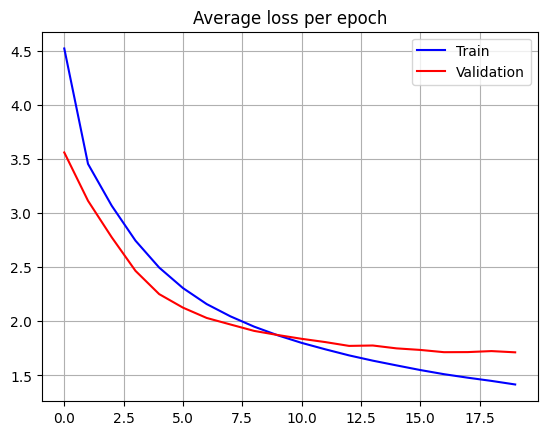

In [77]:
plt.plot(train_losses, color="blue", label="Train")
plt.plot(valid_losses, color="red", label="Validation")
plt.legend()
plt.grid()
plt.title("Average loss per epoch")

### Evaluate

In [34]:
translator.load_state_dict(torch.load(f"models/translator_transformer_{num_layers}_layers_bestval.pt", map_location=device))
translator.eval()

/var/folders/4s/mv0mfx752sb76dmyd9_tr18w0000gn/T/ipykernel_46015/2036248109.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  translator.load_state_dict(torch.load(f"model

TranslatorModel(
  (encoder): Encoder(
    (token_embedding): Embedding(5374, 256)
    (positional_embedding): Embedding(100, 256)
    (dropout): Dropout(p=0.3, inplace=False)
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (norm_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm_2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.3, inplace=False)
        (ff): PositionWiseFeedForward(
          (fc_1): Linear(in_features=256, out_features=512, bias=True)
          (fc_2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (mha): MultiHeadAttention(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (out): Linear(in_features=256, out_features=256, bias=True)
          (dro

In [35]:
random_eval_idx = int(np.random.choice(list(range(NUM_EXAMPLES))))
print_sentences(data=train_data, idx=random_eval_idx, model=translator, src_lang=src_lang, tgt_lang=tgt_lang, device=device)

SOURCE: <BOS> drei personen gehen mitten am tag auf einem pfad . <EOS>
TARGET: <BOS> three people walking on a trail in the middle of the day . <EOS>
MODEL: three people walk on a path in the middle of a day . <EOS> .


In [36]:
idxs = [42, 422, 10, 7, 999]

for idx in idxs:
    print_sentences(data=train_data, idx=idx, model=translator, src_lang=src_lang, tgt_lang=tgt_lang, device=device)
    print("-" * 100)

SOURCE: <BOS> ein mann geht an einem silbernen fahrzeug vorbei . <EOS>
TARGET: <BOS> a man walks by a silver vehicle . <EOS>
MODEL: a man walks past a silver vehicle . <EOS> .
----------------------------------------------------------------------------------------------------
SOURCE: <BOS> drei personen mit langen hosen sitzen im freien auf kleinen steinen hinter einem großen busch . <EOS>
TARGET: <BOS> three people sitting outside on small rocks behind a big bush , wearing long pants . <EOS>
MODEL: three people wearing outside on large stone behind a large bush wearing wearing long pants . <EOS> .
----------------------------------------------------------------------------------------------------
SOURCE: <BOS> eine <UNK> mit fünf mädchen , die nacheinander springen . <EOS>
TARGET: <BOS> a ballet class of five girls jumping in <UNK> . <EOS>
MODEL: a ballet dancer with five girls , in martial . <EOS> .
-------------------------------------------------------------------------------------

In [233]:
bleu = evaluate.load("bleu")

def get_tokenizer_fn(nlp: Language, lower: bool):
    def tokenizer_fn(s):
        tokens = [token.text for token in nlp.tokenizer(s)]
        if lower:
            tokens = [token.lower() for token in tokens]
        return tokens

    return tokenizer_fn

tokenizer_fn = get_tokenizer_fn(en_nlp, lower)

In [81]:
# compute BLEU metric on test data
predictions, references = [], []
for idx in tqdm(range(test_data.num_rows)):
    data_eval_src = test_data[idx]["de_ids"].reshape(1, -1).to(device)
    sentence_evaluated = translate(model=translator,
                                   src=data_eval_src,
                                   src_lang=src_lang,
                                   tgt_lang=tgt_lang,
                                   max_tgt_length=100,
                                   device=device,
                                   clean=True)


    predictions.append(sentence_evaluated)
    references.append(test_data[idx]["en"])

bleu.compute(predictions=predictions, references=references, tokenizer=tokenizer_fn)

100%|██████████| 1000/1000 [00:23<00:00, 42.44it/s]


{'bleu': 0.3579121631025168,
 'precisions': [0.67200546531046,
  0.4322326269098078,
  0.2882584571326293,
  0.19598977786514646],
 'brevity_penalty': 1.0,
 'length_ratio': 1.0088834431000153,
 'translation_length': 13174,
 'reference_length': 13058}